In [2]:
import os
import sys
# module_path = os.path.abspath(os.path.join('../../src'))
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import os
from matplotlib import pyplot as plt

from utils.file import load_from_json
from utils.model import load_lenet, load_pool
from attacks.attack import generate
from utils.metrics import error_rate
from models.athena import Ensemble, ENSEMBLE_STRATEGY

Using TensorFlow backend.
C:\Users\hezek\.conda\envs\athena\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\t

In [3]:
# global variables
CONFIG_ROOT = "../src/configs/"

## (Optional) Prepare a smaller dataset for your experiment

To reduce computational burden, a smaller dataset collected by sampling the full MNIST dataset at a ratio of 0.1 for the `Task 1` was used for this task to ensure consistency and allow for proper comparison.

* python example: `tutorials/subsamples.py`
* api: `utils.data.subsampling`

# Generate adversarial examples

We implement the optimization-based attacks, a naive approach by averaging the losses and an approach that extends EOT for ensemble (``Equation (7)`` in the ``ATHENA`` paper).

## Averaging the losses
Extend ``Equation (1)`` for ensemble by averaging the losses of individual WDs in the ensemble.

\begin{equation*}
max_{\delta}\frac{1}{K}\Sigma_{i=1}^{K}\left(\mathcal{L}\left(f_i, \textbf{x}+\delta, y_{true}\right)\right).
\end{equation*}

where $f_i$ is a weak defense in the targeted ensemble.

----
### How to configure the attack
Same as in ``Task 1``.

----
* python example: `tutorials/craft_adversarial_examples.py`
* main api: `attacks.attack.generate`
* check tunable parameters for each attack in file `attacks/attack.py`.

In [4]:
# copied from tutorials/craft_adversarial_examples.py
def generate_ae(model, data, labels, attack_configs,
                eot=False,
                save=False, output_dir=None):
    """
    Generate adversarial examples
    :param model: WeakDefense. The targeted model.
    :param data: array. The benign samples to generate adversarial for.
    :param labels: array or list. The true labels.
    :param attack_configs: dictionary. Attacks and corresponding settings.
    :param save: boolean. True, if save the adversarial examples.
    :param output_dir: str or path. Location to save the adversarial examples.
        It cannot be None when save is True.
    :return:
    """
    img_rows, img_cols = data.shape[1], data.shape[2]
    num_attacks = attack_configs.get("num_attacks")
    data_loader = (data, labels)

    if len(labels.shape) > 1:
        labels = np.asarray([np.argmax(p) for p in labels])

    # generate attacks one by one
    for id in range(num_attacks):
        key = "configs{}".format(id)
        attack_args = attack_configs.get(key)
        
        attack_args["eot"] = eot
        data_adv = generate(model=model,
                            data_loader=data_loader,
                            attack_args=attack_args
                            )
        # predict the adversarial examples
        predictions = model.predict(data_adv)
        predictions = np.asarray([np.argmax(p) for p in predictions])

        err = error_rate(y_pred=predictions, y_true=labels)
        print(">>> error rate:", err)

        # plotting some examples
        num_plotting = min(data.shape[0], 2)
        for i in range(num_plotting):
            img = data_adv[i].reshape((img_rows, img_cols))
            plt.imshow(img, cmap='gray')
            title = '{}(EOT:{}): {}->{}'.format(attack_configs.get(key).get("description"),
                                                "ON" if eot else "OFF",
                                                labels[i],
                                                predictions[i]
                                                )
            plt.title(title)
            plt.show()
            plt.close()

        # save the adversarial example
        if save:
            if output_dir is None:
                raise ValueError("Cannot save images to a none path.")
            # save with a random name
            file = os.path.join(output_dir, "{}.npy".format(attack_configs.get(key).get("description")))
#             file = os.path.join(output_dir, "{}.npy".format(time.monotonic()))
            print("Save the adversarial examples to file [{}].".format(file))
            np.save(file, data_adv)

## EOT attack
* paper: [Synthesizing Robust Adversarial Examples](https://arxiv.org/pdf/1707.07397.pdf)
* code GitHub repo: [EOT](https://github.com/prabhant/synthesizing-robust-adversarial-examples)
* ATHENA paper: [ATHENA: A Framework based on Diverse Weak Defenses for Building Adversarial Defense](https://arxiv.org/abs/2001.00308)

We extend ``EOT`` for ensemble in the ``ATHENA`` paper (``Equation (7)``). Currently, we support ``FGSM`` and ``PGD`` as the adversarial optimizer. You will need to provide the configuration for the chosen distribution.

----
### How to configure the distribution
In ``attack-zk-mnist.json``, add a key-value pair: key --- ``"distribution"``; value --- dictionary. configuration for the distribution.

e.g.,
```json
"configs1": {
    "attack": "pgd",
    "description": "PGD_eps0.3",
    "eps": 0.3,
    "distribution": {
      "num_samples": 100,
      "transformation": "translation",
      "min_offset": -0.2,
      "max_offset": 0.2
    }
}

```
where ``num_samples`` is the number of random sampled transformations from the chosen distribution. For detailed explanation, please refer to the ``EOT`` and ``ATHENA`` paper.

Tune the factors to generate AEs variants with various effectiveness:
* parameters of the selected attack method (e.g., ``eps``, ``eps_step``, ``max_iter``, and the like, for ``PGD``).
* distribution settings: ``num_samples``, ``transformation`` and corresponding settings.

----
* python example: `tutorials/craft_adversarial_examples.py`.
* main api: `attacks.attack.generate`.
* check tunable parameters for each attack in file `attacks/attack.py`.
* check tunable parameters for distributions in file `attacks/distribution.py`.

>>> Loading model [../models/cnn/model-mnist-cnn-rotate90.h5]...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
>>> Loading model [../models/cnn/model-mnist-cnn-shift_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_top_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_bottom_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-flip_horizontal.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_horizontal_compress.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_both_stretch.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-morph_gradient.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-cartoon_mean_type3.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-cartoon_gaussian_type4.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-distort_y.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-noise_salt.h5]...
>>> Loading mo

C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:73: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _segment_trans(X, trans_args)


>>> error rate: 0.018


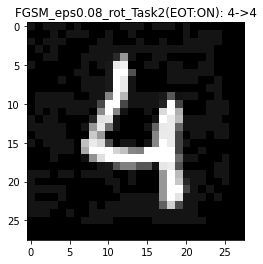

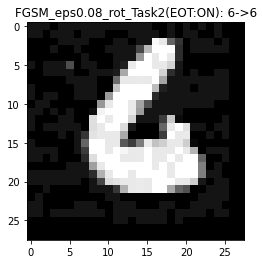

Save the adversarial examples to file [../task2_gen\FGSM_eps0.08_rot_Task2.npy].
>>> Generating FGSM_eps0.15_rot_Task2(EOT:ON) examples.
>>> error rate: 0.034


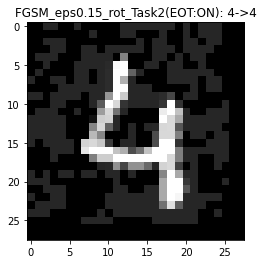

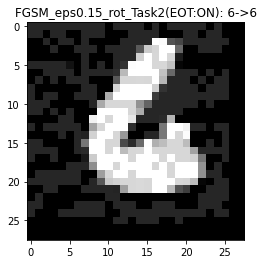

Save the adversarial examples to file [../task2_gen\FGSM_eps0.15_rot_Task2.npy].
>>> Generating FGSM_eps0.20_rot_Task2(EOT:ON) examples.
>>> error rate: 0.041


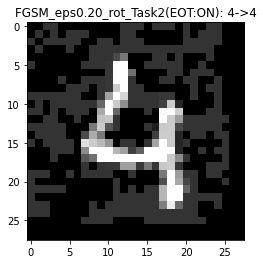

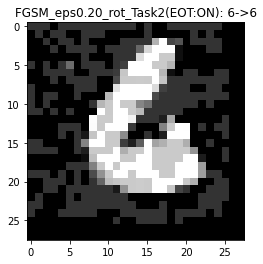

Save the adversarial examples to file [../task2_gen\FGSM_eps0.20_rot_Task2.npy].
>>> Generating FGSM_eps0.25_rot_Task2(EOT:ON) examples.
>>> error rate: 0.096


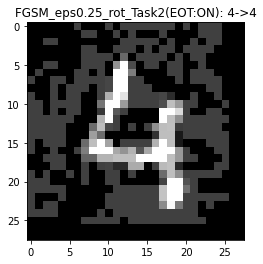

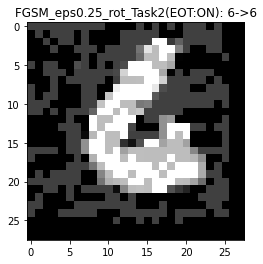

Save the adversarial examples to file [../task2_gen\FGSM_eps0.25_rot_Task2.npy].
>>> Generating FGSM_eps0.30_rot_Task2(EOT:ON) examples.
>>> error rate: 0.236


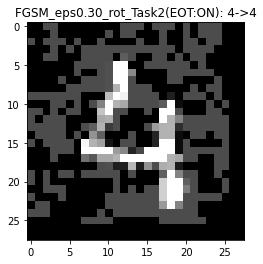

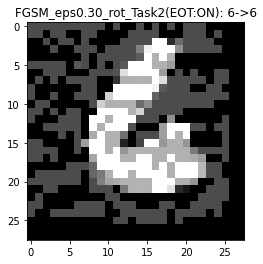

Save the adversarial examples to file [../task2_gen\FGSM_eps0.30_rot_Task2.npy].
>>> Generating FGSM_eps0.40_rot_Task2(EOT:ON) examples.
>>> error rate: 0.659


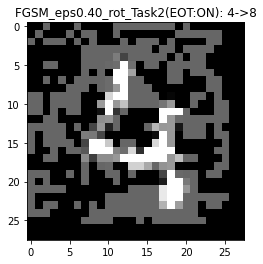

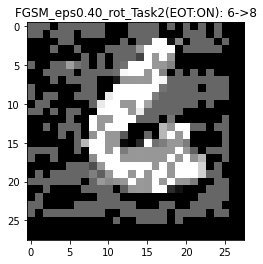

Save the adversarial examples to file [../task2_gen\FGSM_eps0.40_rot_Task2.npy].
>>> Generating FGSM_eps0.08_tran_Task2(EOT:ON) examples.
>>> error rate: 0.013


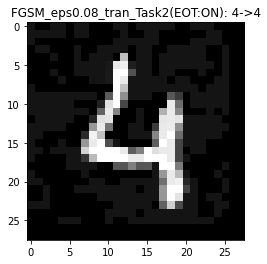

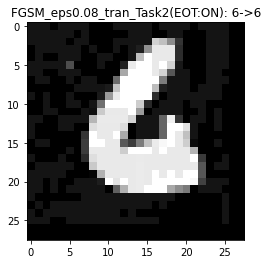

Save the adversarial examples to file [../task2_gen\FGSM_eps0.08_tran_Task2.npy].
>>> Generating FGSM_eps0.15_tran_Task2(EOT:ON) examples.
>>> error rate: 0.019


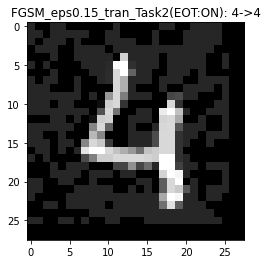

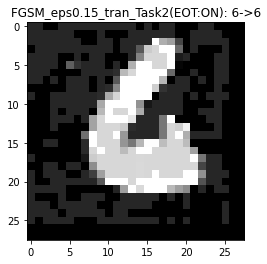

Save the adversarial examples to file [../task2_gen\FGSM_eps0.15_tran_Task2.npy].
>>> Generating FGSM_eps0.20_tran_Task2(EOT:ON) examples.
>>> error rate: 0.028


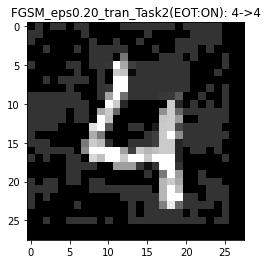

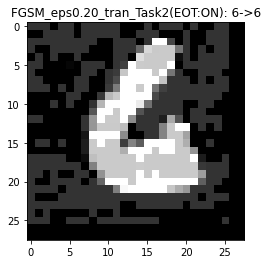

Save the adversarial examples to file [../task2_gen\FGSM_eps0.20_tran_Task2.npy].
>>> Generating FGSM_eps0.25_tran_Task2(EOT:ON) examples.
>>> error rate: 0.069


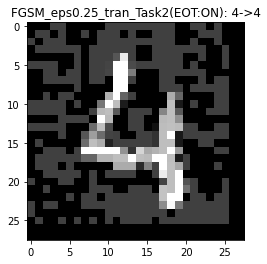

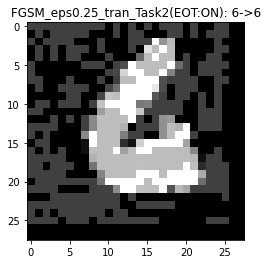

Save the adversarial examples to file [../task2_gen\FGSM_eps0.25_tran_Task2.npy].
>>> Generating FGSM_eps0.30_tran_Task2(EOT:ON) examples.
>>> error rate: 0.161


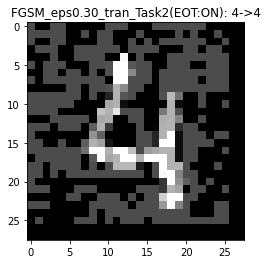

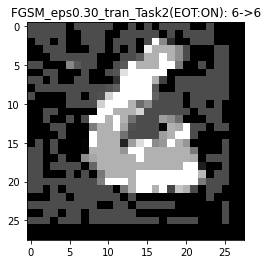

Save the adversarial examples to file [../task2_gen\FGSM_eps0.30_tran_Task2.npy].
>>> Generating FGSM_eps0.40_tran_Task2(EOT:ON) examples.
>>> error rate: 0.562


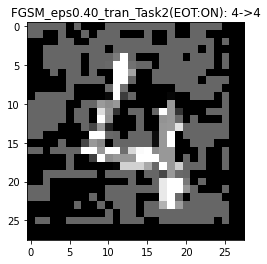

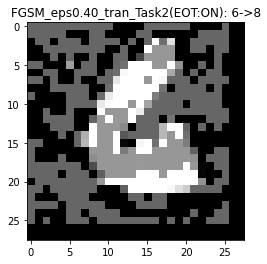

Save the adversarial examples to file [../task2_gen\FGSM_eps0.40_tran_Task2.npy].
>>> Generating PGD_eps0.08_tran_50_Task2(EOT:ON) examples.
>>> error rate: 0.014


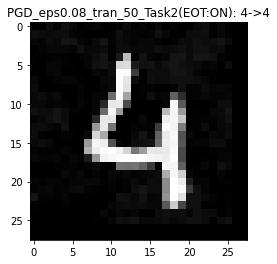

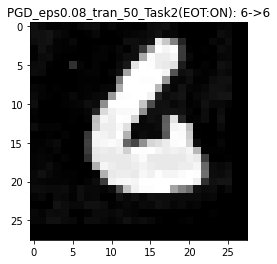

Save the adversarial examples to file [../task2_gen\PGD_eps0.08_tran_50_Task2.npy].
>>> Generating PGD_eps0.15_tran_50_Task2(EOT:ON) examples.
>>> error rate: 0.019


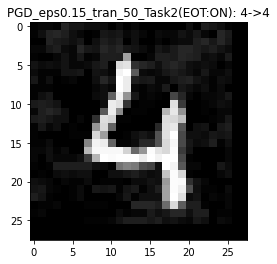

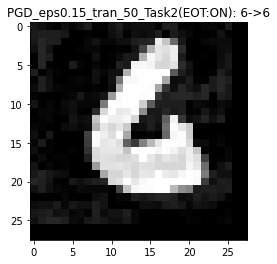

Save the adversarial examples to file [../task2_gen\PGD_eps0.15_tran_50_Task2.npy].
>>> Generating PGD_eps0.20_tran_50_Task2(EOT:ON) examples.
>>> error rate: 0.023


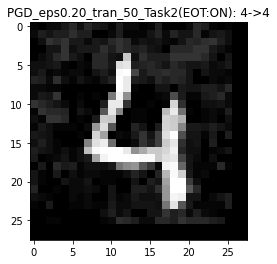

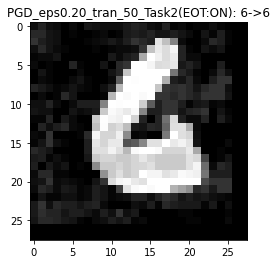

Save the adversarial examples to file [../task2_gen\PGD_eps0.20_tran_50_Task2.npy].
>>> Generating PGD_eps0.25_tran_50_Task2(EOT:ON) examples.
>>> error rate: 0.029


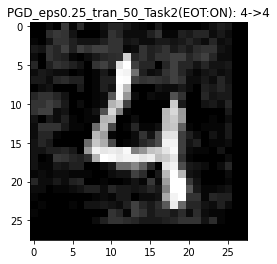

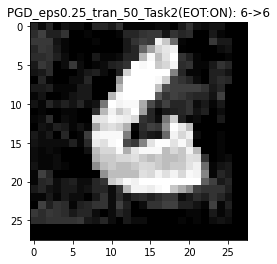

Save the adversarial examples to file [../task2_gen\PGD_eps0.25_tran_50_Task2.npy].
>>> Generating PGD_eps0.30_tran_50_Task2(EOT:ON) examples.
>>> error rate: 0.038


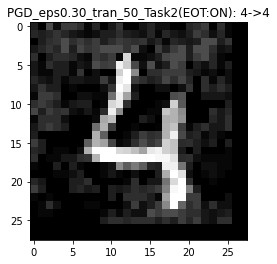

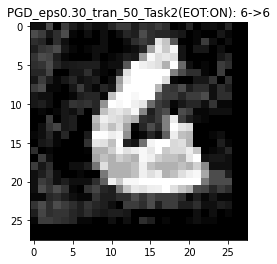

Save the adversarial examples to file [../task2_gen\PGD_eps0.30_tran_50_Task2.npy].
>>> Generating PGD_eps0.40_tran_50_Task2(EOT:ON) examples.
>>> error rate: 0.094


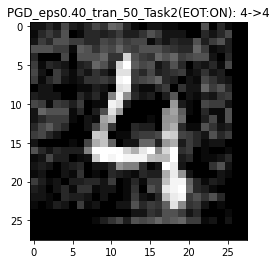

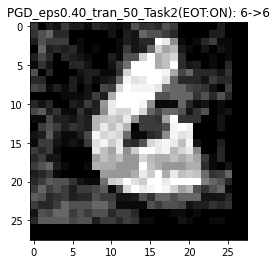

Save the adversarial examples to file [../task2_gen\PGD_eps0.40_tran_50_Task2.npy].
>>> Generating PGD_eps0.08_tran_100_Task2(EOT:ON) examples.
>>> error rate: 0.015


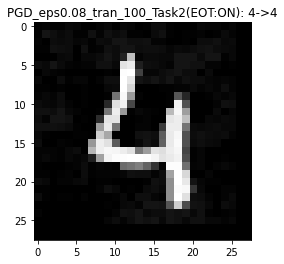

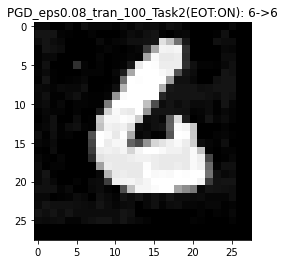

Save the adversarial examples to file [../task2_gen\PGD_eps0.08_tran_100_Task2.npy].
>>> Generating PGD_eps0.15_tran_100_Task2(EOT:ON) examples.
>>> error rate: 0.025


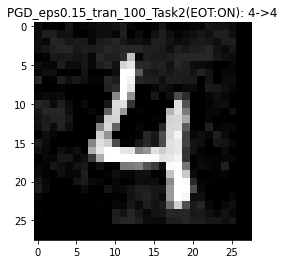

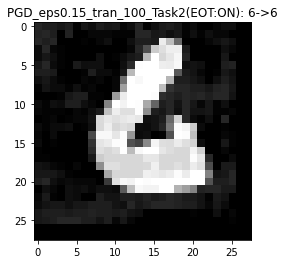

Save the adversarial examples to file [../task2_gen\PGD_eps0.15_tran_100_Task2.npy].
>>> Generating PGD_eps0.20_tran_100_Task2(EOT:ON) examples.
>>> error rate: 0.026


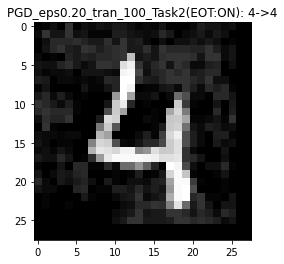

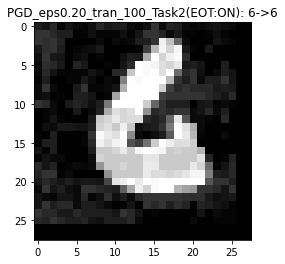

Save the adversarial examples to file [../task2_gen\PGD_eps0.20_tran_100_Task2.npy].
>>> Generating PGD_eps0.25_tran_100_Task2(EOT:ON) examples.
>>> error rate: 0.038


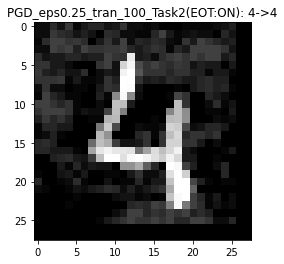

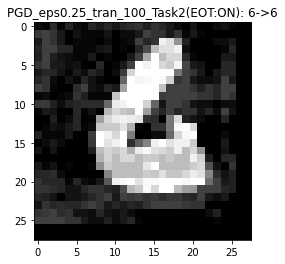

Save the adversarial examples to file [../task2_gen\PGD_eps0.25_tran_100_Task2.npy].
>>> Generating PGD_eps0.30_tran_100_Task2(EOT:ON) examples.
>>> error rate: 0.06


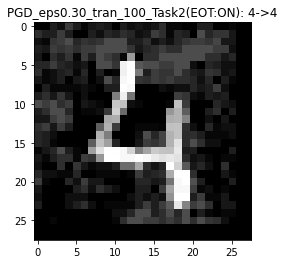

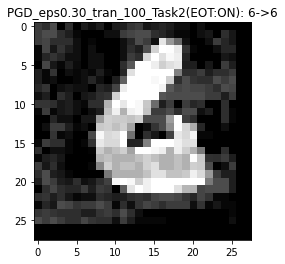

Save the adversarial examples to file [../task2_gen\PGD_eps0.30_tran_100_Task2.npy].


In [4]:
# loading experiment configurations
trans_configs = load_from_json(CONFIG_ROOT + "demo/athena-mnist.json")
model_configs = load_from_json(CONFIG_ROOT + "demo/model-mnist.json")
data_configs = load_from_json(CONFIG_ROOT + "demo/data-mnist.json")
attack_configs = load_from_json(CONFIG_ROOT + "demo/attack-zk-mnist.json")

# load weak defenses into a pool
pool, _ = load_pool(trans_configs=trans_configs,
                    model_configs=model_configs,
                    active_list=True,
                    wrap=True)
# create an AVEP ensemble from the WD pool
wds = list(pool.values())
target = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)

# load the benign samples
data_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
data_bs = np.load(data_file)
# load the corresponding true labels
label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
labels = np.load(label_file)

# generate AEs
# in this example, we generate AEs for 5 benign samples
# data_bs = data_bs[:5]
data_bs = data_bs[:]
labels = labels[:]

# Adaptive approach (with EOT)
# Compute the loss expectation over specific distribution.
# For an ensemble target, averaging the EOT of WDs'.
# let save=True and specify an output folder to save the generated AEs
generate_ae(model=target, data=data_bs, labels=labels, eot=True, save=True, attack_configs=attack_configs,output_dir='../task2_gen')

## Generating the last one for PGD with translation at maximum iteration of 100

Due to a slight error in the initial config, we had to generate the last AEs separately.

>>> Loading model [../models/cnn/model-mnist-cnn-rotate90.h5]...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
>>> Loading model [../models/cnn/model-mnist-cnn-shift_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_top_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-shift_bottom_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-flip_horizontal.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_horizontal_compress.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_both_stretch.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-morph_gradient.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-cartoon_mean_type3.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-cartoon_gaussian_type4.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-distort_y.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-noise_salt.h5]...
>>> Loading mo

C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:65: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _filter_trans(X, trans_args)
C:\Users\hezek\Documents\ML\project-athena-master-Task2\src\models\image_processor.py:73: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  return _segment_trans(X, trans_args)


>>> error rate: 0.167


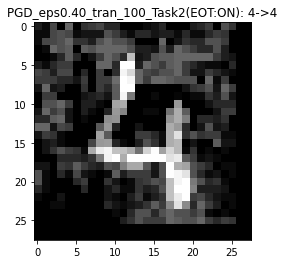

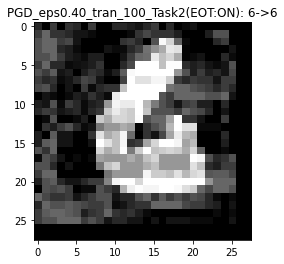

Save the adversarial examples to file [../task2_gen\PGD_eps0.40_tran_100_Task2.npy].


In [5]:
# loading experiment configurations
trans_configs = load_from_json(CONFIG_ROOT + "demo/athena-mnist.json")
model_configs = load_from_json(CONFIG_ROOT + "demo/model-mnist.json")
data_configs = load_from_json(CONFIG_ROOT + "demo/data-mnist.json")
attack_configs = load_from_json(CONFIG_ROOT + "demo/attack-zk-mnist.json")

# load weak defenses into a pool
pool, _ = load_pool(trans_configs=trans_configs,
                    model_configs=model_configs,
                    active_list=True,
                    wrap=True)
# create an AVEP ensemble from the WD pool
wds = list(pool.values())
target = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)

# load the benign samples
data_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
data_bs = np.load(data_file)
# load the corresponding true labels
label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
labels = np.load(label_file)

# generate AEs
# in this example, we generate AEs for 5 benign samples
# data_bs = data_bs[:5]
data_bs = data_bs[:]
labels = labels[:]

# Adaptive approach (with EOT)
# Compute the loss expectation over specific distribution.
# For an ensemble target, averaging the EOT of WDs'.
# let save=True and specify an output folder to save the generated AEs
generate_ae(model=target, data=data_bs, labels=labels, eot=True, save=True, attack_configs=attack_configs,output_dir='../task2_gen')